In [ ]:
!pip install -q kaggle

import os, json, shutil

# 1) перемещаем kaggle.json, который ты загрузишь через Files в /content
os.makedirs(os.path.join(os.path.expanduser("~"), ".kaggle"), exist_ok=True)
if os.path.exists("kaggle.json"):
    shutil.move("kaggle.json", os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json"))
    print("kaggle.json перемещён в ~/.kaggle")
else:
    print("⚠️ Загрузите kaggle.json в /content через панель Files!")

os.chmod(os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json"), 0o600)

# 2) создаём папку data и скачиваем датасет Fantacher "Metal Surface Defects Dataset" [web:25][web:28]
os.makedirs("data", exist_ok=True)

!kaggle datasets download -d fantacher/neu-metal-surface-defects-data -p data

# 3) распаковываем zip
import zipfile
zip_path = "data/neu-metal-surface-defects-data.zip"
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall("data")
print("Распаковано в ./data")


kaggle.json перемещён в ~/.kaggle
Dataset URL: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data
License(s): other
  0% 0.00/57.4M [00:00<?, ?B/s]
100% 57.4M/57.4M [00:00<00:00, 1.13GB/s]
Распаковано в ./data


In [ ]:
import tensorflow as tf

# ищем папку, где лежат 6 подпапок классов (Crazing, Inclusion, Patches, Pitted, Rolled, Scratches) [web:25][web:33]
def find_class_root(base_dir):
    for root, dirs, files in os.walk(base_dir):
        lower_dirs = [d.lower() for d in dirs]
        needed = ["crazing", "inclusion", "patches", "pitted", "rolled", "scratches"]
        if all(any(nd == need for nd in lower_dirs) for need in needed):
            return root
    return None

BASE_DIR = "./data"
train_root = find_class_root(BASE_DIR)
print("train_root =", train_root)
print("Подпапки:", os.listdir(train_root))

CONFIG = {
    "img_height": 128,
    "img_width": 128,
    "batch_size": 32,
    "seed": 42,
    "val_split": 0.2,
    "test_split": 0.1,
    "epochs": 15,
    "base_filters": 32,
    "conv_blocks": 3,
    "dropout": 0.4,
    "learning_rate": 1e-3,
}

IMG_SIZE   = (CONFIG["img_height"], CONFIG["img_width"])
BATCH_SIZE = CONFIG["batch_size"]
SEED       = CONFIG["seed"]

full_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
)

class_names = full_ds.class_names
num_classes = len(class_names)
print("class_names:", class_names, "num_classes =", num_classes)

total_batches = tf.data.experimental.cardinality(full_ds).numpy()
val_batches   = int(total_batches * CONFIG["val_split"])
test_batches  = int(total_batches * CONFIG["test_split"])
train_batches = total_batches - val_batches - test_batches

print(f"Всего батчей: {total_batches}")
print(f"Train: {train_batches}, Val: {val_batches}, Test: {test_batches}")

train_ds = full_ds.take(train_batches)
val_ds   = full_ds.skip(train_batches).take(val_batches)
test_ds  = full_ds.skip(train_batches + val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


train_root = ./data/NEU Metal Surface Defects Data/valid
Подпапки: ['Inclusion', 'Scratches', 'Crazing', 'Rolled', 'Patches', 'Pitted']
Found 72 files belonging to 6 classes.
class_names: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches'] num_classes = 6
Всего батчей: 3
Train: 3, Val: 0, Test: 0


In [ ]:
train_root = "./data/NEU Metal Surface Defects Data/train"
print("train_root =", train_root)
print("Подпапки:", os.listdir(train_root))


train_root = ./data/NEU Metal Surface Defects Data/train
Подпапки: ['Inclusion', 'Scratches', 'Crazing', 'Rolled', 'Patches', 'Pitted']


In [ ]:
IMG_SIZE   = (CONFIG["img_height"], CONFIG["img_width"])
BATCH_SIZE = CONFIG["batch_size"]
SEED       = CONFIG["seed"]

full_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
)

class_names = full_ds.class_names
num_classes = len(class_names)

total_batches = tf.data.experimental.cardinality(full_ds).numpy()
val_batches   = int(total_batches * CONFIG["val_split"])
test_batches  = int(total_batches * CONFIG["test_split"])
train_batches = total_batches - val_batches - test_batches

print(f"Всего батчей: {total_batches}")
print(f"Train: {train_batches}, Val: {val_batches}, Test: {test_batches}")


Found 1656 files belonging to 6 classes.
Всего батчей: 52
Train: 37, Val: 10, Test: 5


train_root = ./data/NEU Metal Surface Defects Data/train
Подпапки: ['Inclusion', 'Scratches', 'Crazing', 'Rolled', 'Patches', 'Pitted']
Found 1656 files belonging to 6 classes.
class_names: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches'] num_classes = 6
Всего батчей: 52
Train: 37, Val: 10, Test: 5
train_ds batches: 37
val_ds batches: 10
test_ds batches: 5


Model: "metal_defect_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,677,414 (33.10 MB)

 Trainable params: 8,677,414 (33.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.1766 - loss: 1.7873 - val_accuracy: 0.1437 - val_loss: 1.8024
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.1966 - loss: 1.7961 - val_accuracy: 0.2750 - val_loss: 1.6295
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.2496 - loss: 1.6596 - val_accuracy: 0.3063 - val_loss: 1.6564
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.2700 - loss: 1.6366 - val_accuracy: 0.1844 - val_loss: 1.7903
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.1811 - loss: 1.7525 - val_accuracy: 0.2875 - val_loss: 1.6241
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.3072 - loss: 1.5840 - val_accuracy: 0.3281 - val_loss: 1.5298
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.3357 - loss: 1.5400 - val_accuracy: 0.3781 - val_loss: 1.4612
Epoch 8/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.3498 - loss: 1.4927 - val_accuracy: 0.3313 - v

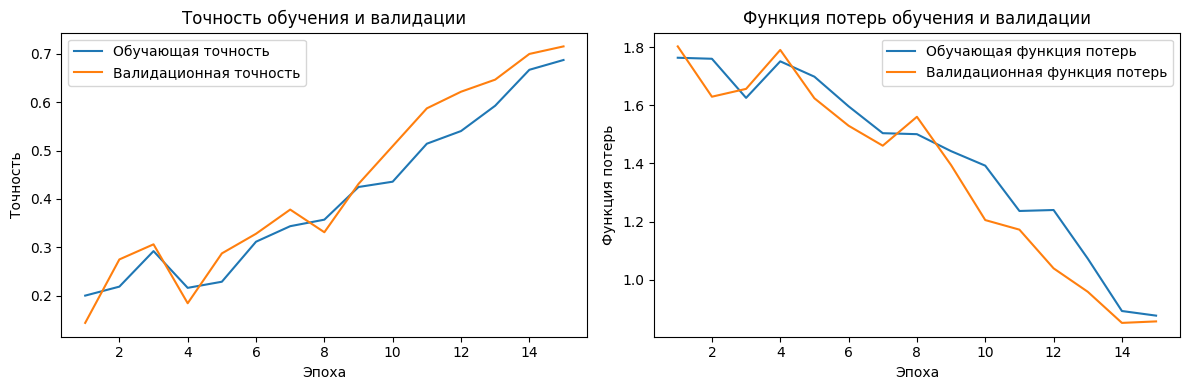

In [ ]:
import os, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. ДАННЫЕ
train_root = "./data/NEU Metal Surface Defects Data/train"
print("train_root =", train_root)
print("Подпапки:", os.listdir(train_root))

IMG_SIZE   = (CONFIG["img_height"], CONFIG["img_width"])
BATCH_SIZE = CONFIG["batch_size"]
SEED       = CONFIG["seed"]

full_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
)

class_names = full_ds.class_names
num_classes = len(class_names)
print("class_names:", class_names, "num_classes =", num_classes)

total_batches = tf.data.experimental.cardinality(full_ds).numpy()
val_batches   = int(total_batches * CONFIG["val_split"])
test_batches  = int(total_batches * CONFIG["test_split"])
train_batches = total_batches - val_batches - test_batches

print(f"Всего батчей: {total_batches}")
print(f"Train: {train_batches}, Val: {val_batches}, Test: {test_batches}")

train_ds = full_ds.take(train_batches)
val_ds   = full_ds.skip(train_batches).take(val_batches)
test_ds  = full_ds.skip(train_batches + val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

print("train_ds batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("val_ds batches:",   tf.data.experimental.cardinality(val_ds).numpy())
print("test_ds batches:",  tf.data.experimental.cardinality(test_ds).numpy())

# 2. МОДЕЛЬ
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

def build_cnn_model(
    img_size=IMG_SIZE,
    num_classes=num_classes,
    base_filters=32,
    conv_blocks=3,
    dropout=0.4,
):
    inputs = keras.Input(shape=img_size + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)

    filters = base_filters
    for _ in range(conv_blocks):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        filters *= 2

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="metal_defect_cnn")
    return model

model = build_cnn_model(
    img_size=IMG_SIZE,
    num_classes=num_classes,
    base_filters=CONFIG["base_filters"],
    conv_blocks=CONFIG["conv_blocks"],
    dropout=CONFIG["dropout"],
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
]

# 3. ОБУЧЕНИЕ
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["epochs"],
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

# 4. ГРАФИКИ
acc      = history.history["accuracy"]
val_acc  = history.history["val_accuracy"]
loss     = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Обучающая точность")
plt.plot(epochs_range, val_acc, label="Валидационная точность")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность обучения и валидации")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Обучающая функция потерь")
plt.plot(epochs_range, val_loss, label="Валидационная функция потерь")
plt.xlabel("Эпоха")
plt.ylabel("Функция потерь")
plt.title("Функция потерь обучения и валидации")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def build_cnn_model_v2(img_size=IMG_SIZE, num_classes=num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)

    # пример: только 2 блока вместо 3
    for filters in [32, 64]:
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="metal_defect_cnn_v2")

model2 = build_cnn_model_v2()
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["epochs"],
)

test_loss2, test_acc2 = model2.evaluate(test_ds)
print("Model2 test acc:", test_acc2)


Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.1800 - loss: 1.8597 - val_accuracy: 0.3063 - val_loss: 1.6398
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.2815 - loss: 1.6358 - val_accuracy: 0.3938 - val_loss: 1.5456
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.3778 - loss: 1.5183 - val_accuracy: 0.4437 - val_loss: 1.3653
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.3936 - loss: 1.4873 - val_accuracy: 0.3469 - val_loss: 1.4891
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.3783 - loss: 1.5045 - val_accuracy: 0.5656 - val_loss: 1.3406
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4603 - loss: 1.3814 - val_accuracy: 0.5469 - val_loss: 1.2053
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.5007 - loss: 1.2725 - val_accuracy: 0.5594 - val_loss: 1.1582
Epoch 8/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.5240 - loss: 1.2159 - val_accuracy: 0.5312 - val_l

In [ ]:
!pip install -q kaggle

import os, shutil, zipfile

# 1) kaggle.json загрузи через панель Files в /content, потом:
os.makedirs(os.path.join(os.path.expanduser("~"), ".kaggle"), exist_ok=True)
if os.path.exists("kaggle.json"):
    shutil.move("kaggle.json", os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json"))
    print("kaggle.json перемещён")
os.chmod(os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json"), 0o600)

# 2) скачиваем датасет
os.makedirs("data", exist_ok=True)
!kaggle datasets download -d fantacher/neu-metal-surface-defects-data -p data


kaggle.json перемещён
Dataset URL: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data
License(s): other
  0% 0.00/57.4M [00:00<?, ?B/s]
100% 57.4M/57.4M [00:00<00:00, 1.43GB/s]


In [ ]:
import zipfile, os

zip_path = "data/neu-metal-surface-defects-data.zip"
extract_dir = "data"

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)

print("Содержимое ./data:", os.listdir("data"))


Содержимое ./data: ['NEU Metal Surface Defects Data', 'neu-metal-surface-defects-data.zip']


train_root = ./data/NEU Metal Surface Defects Data/train
Подпапки train: ['Inclusion', 'Scratches', 'Crazing', 'Rolled', 'Patches', 'Pitted']
Found 1656 files belonging to 6 classes.
class_names: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches'] num_classes = 6
Всего батчей: 52
Train: 37, Val: 10, Test: 5
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.1901 - loss: 2.0726 - val_accuracy: 0.2438 - val_loss: 1.6450
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.3052 - loss: 1.6903 - val_accuracy: 0.3656 - val_loss: 1.5624
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.2904 - loss: 1.6613 - val_accuracy: 0.3156 - val_loss: 1.5202
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.3027 - loss: 1.6669 - val_accuracy: 0.5375 - val_loss: 1.4959
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.3743 - loss: 1.5106 - val_accuracy: 0.4719 - val_loss: 1.3571
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1

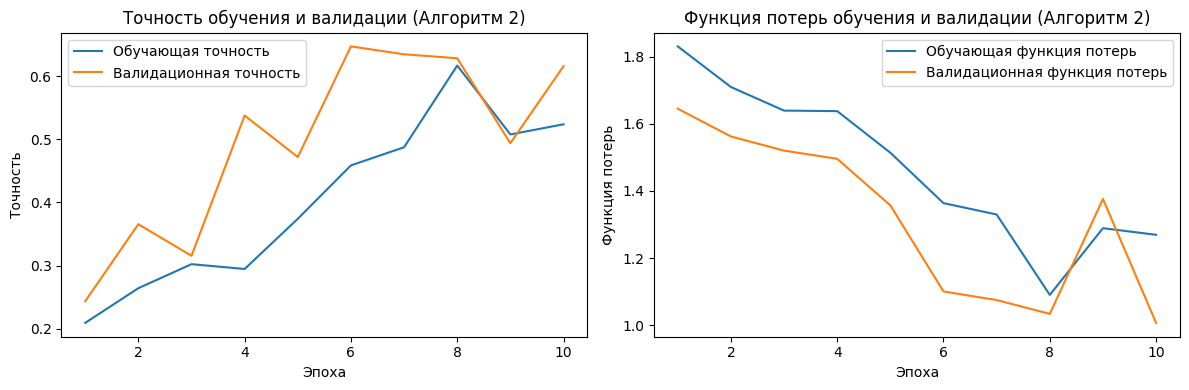

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

CONFIG = {
    "img_height": 128,
    "img_width": 128,
    "batch_size": 32,
    "seed": 42,
    "val_split": 0.2,
    "test_split": 0.1,
    "epochs": 10,
    "learning_rate": 1e-3,
}

train_root = "./data/NEU Metal Surface Defects Data/train"
print("train_root =", train_root)
print("Подпапки train:", os.listdir(train_root))

IMG_SIZE   = (CONFIG["img_height"], CONFIG["img_width"])
BATCH_SIZE = CONFIG["batch_size"]
SEED       = CONFIG["seed"]

full_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
)

class_names = full_ds.class_names
num_classes = len(class_names)
print("class_names:", class_names, "num_classes =", num_classes)

total_batches = tf.data.experimental.cardinality(full_ds).numpy()
val_batches   = int(total_batches * CONFIG["val_split"])
test_batches  = int(total_batches * CONFIG["test_split"])
train_batches = total_batches - val_batches - test_batches

print(f"Всего батчей: {total_batches}")
print(f"Train: {train_batches}, Val: {val_batches}, Test: {test_batches}")

train_ds = full_ds.take(train_batches)
val_ds   = full_ds.skip(train_batches).take(val_batches)
test_ds  = full_ds.skip(train_batches + val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

def build_cnn_model_v2(img_size=IMG_SIZE, num_classes=num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)

    for filters in [32, 64]:
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="metal_defect_cnn_v2")

model2 = build_cnn_model_v2()
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["epochs"],
)

test_loss2, test_acc2 = model2.evaluate(test_ds)
print(f"Model2 test accuracy: {test_acc2:.4f}, loss: {test_loss2:.4f}")

# Графики для Алгоритма 2
acc      = history2.history["accuracy"]
val_acc  = history2.history["val_accuracy"]
loss     = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Обучающая точность")
plt.plot(epochs, val_acc, label="Валидационная точность")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность обучения и валидации (Алгоритм 2)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Обучающая функция потерь")
plt.plot(epochs, val_loss, label="Валидационная функция потерь")
plt.xlabel("Эпоха")
plt.ylabel("Функция потерь")
plt.title("Функция потерь обучения и валидации (Алгоритм 2)")
plt.legend()

plt.tight_layout()
plt.show()


Model: "metal_defect_cnn_v2_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,455,078 (32.25 MB)

 Trainable params: 8,455,078 (32.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.1767 - loss: 1.7857 - val_accuracy: 0.1437 - val_loss: 1.8040
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.2138 - loss: 1.7781 - val_accuracy: 0.1437 - val_loss: 1.7890
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.2289 - loss: 1.7417 - val_accuracy: 0.1937 - val_loss: 1.7578
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.2616 - loss: 1.7128 - val_accuracy: 0.3031 - val_loss: 1.5460
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.3242 - loss: 1.5857 - val_accuracy: 0.3031 - val_loss: 1.5104
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.3236 - loss: 1.5838 - val_accuracy: 0.1781 - val_loss: 1.7258
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.3193 - loss: 1.6145 - val_accuracy: 0.3938 - val_loss: 1.5220
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.3601 - loss: 1.5017 - val_accuracy: 0.4656 - v

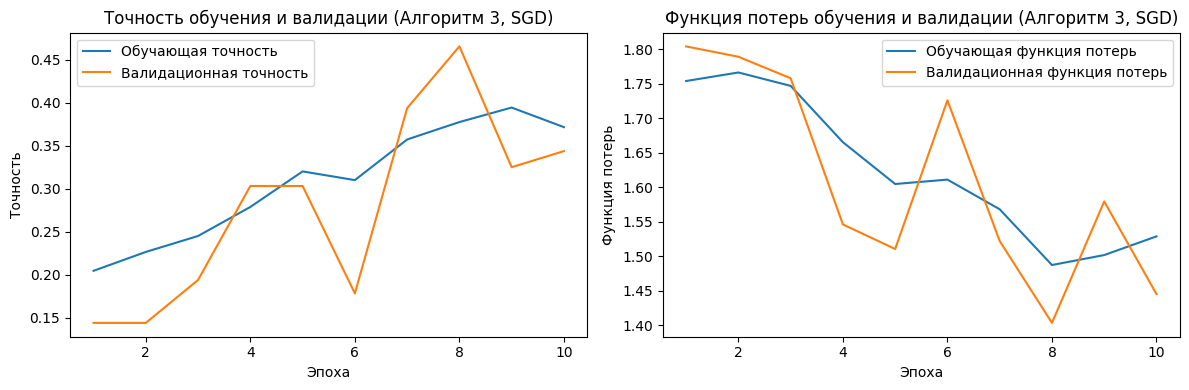

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Модель можно взять такую же, как в Алгоритме 2
def build_cnn_model_v2(img_size=IMG_SIZE, num_classes=num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)

    for filters in [32, 64]:
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="metal_defect_cnn_v2_sgd")

model3 = build_cnn_model_v2()

# ВАЖНО: другой оптимизатор — SGD с momentum
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)  # алгоритм 3

model3.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model3.summary()

history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["epochs"],
)

test_loss3, test_acc3 = model3.evaluate(test_ds)
print(f"Model3 (SGD) test accuracy: {test_acc3:.4f}, loss: {test_loss3:.4f}")

# Графики для Алгоритма 3
acc      = history3.history["accuracy"]
val_acc  = history3.history["val_accuracy"]
loss     = history3.history["loss"]
val_loss = history3.history["val_loss"]
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Обучающая точность")
plt.plot(epochs, val_acc, label="Валидационная точность")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность обучения и валидации (Алгоритм 3, SGD)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Обучающая функция потерь")
plt.plot(epochs, val_loss, label="Валидационная функция потерь")
plt.xlabel("Эпоха")
plt.ylabel("Функция потерь")
plt.title("Функция потерь обучения и валидации (Алгоритм 3, SGD)")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
!pip install -q kaggle

import os, shutil, zipfile

# 1) Загрузите kaggle.json через панель Files в /content
os.makedirs(os.path.join(os.path.expanduser("~"), ".kaggle"), exist_ok=True)
if os.path.exists("kaggle.json"):
    shutil.move("kaggle.json", os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json"))
    print("kaggle.json перемещён в ~/.kaggle")
else:
    print("⚠️ Загрузите kaggle.json в корень /content!")

os.chmod(os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json"), 0o600)

# 2) Скачиваем датасет Fantacher NEU Metal Surface Defects [web:25][web:163]
os.makedirs("data", exist_ok=True)
!kaggle datasets download -d fantacher/neu-metal-surface-defects-data -p data


kaggle.json перемещён в ~/.kaggle
Dataset URL: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data
License(s): other
  0% 0.00/57.4M [00:00<?, ?B/s]
100% 57.4M/57.4M [00:00<00:00, 1.52GB/s]


In [ ]:
import zipfile, os

zip_path = "data/neu-metal-surface-defects-data.zip"
extract_dir = "data"

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)

print("Содержимое ./data:", os.listdir("data"))


Содержимое ./data: ['NEU Metal Surface Defects Data', 'neu-metal-surface-defects-data.zip']


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

CONFIG = {
    "img_height": 128,
    "img_width": 128,
    "batch_size": 32,
    "seed": 42,
    "val_split": 0.2,
    "test_split": 0.1,
    "epochs": 10,
    "learning_rate": 1e-3,
}

train_root = "./data/NEU Metal Surface Defects Data/train"
print("train_root =", train_root)
print("Подпапки train:", os.listdir(train_root))

IMG_SIZE   = (CONFIG["img_height"], CONFIG["img_width"])
BATCH_SIZE = CONFIG["batch_size"]
SEED       = CONFIG["seed"]

full_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
)

class_names = full_ds.class_names
num_classes = len(class_names)
print("class_names:", class_names, "num_classes =", num_classes)

total_batches = tf.data.experimental.cardinality(full_ds).numpy()
val_batches   = int(total_batches * CONFIG["val_split"])
test_batches  = int(total_batches * CONFIG["test_split"])
train_batches = total_batches - val_batches - test_batches

print(f"Всего батчей: {total_batches}")
print(f"Train: {train_batches}, Val: {val_batches}, Test: {test_batches}")

train_ds = full_ds.take(train_batches)
val_ds   = full_ds.skip(train_batches).take(val_batches)
test_ds  = full_ds.skip(train_batches + val_batches)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)


train_root = ./data/NEU Metal Surface Defects Data/train
Подпапки train: ['Inclusion', 'Scratches', 'Crazing', 'Rolled', 'Patches', 'Pitted']
Found 1656 files belonging to 6 classes.
class_names: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches'] num_classes = 6
Всего батчей: 52
Train: 37, Val: 10, Test: 5


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import applications

# 1) Базовая предобученная модель MobileNetV2 [web:111]
base_model = applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # сначала заморожены все слои

# 2) Строим свою «голову» для 6 классов дефектов
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model4 = keras.Model(inputs, outputs, name="mobilenetv2_defects")

model4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model4.summary()

# 3) Обучение (Алгоритм 4)
history4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["epochs"],
)

test_loss4, test_acc4 = model4.evaluate(test_ds)
print(f"MobileNetV2 test accuracy: {test_acc4:.4f}, loss: {test_loss4:.4f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_defects"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - accuracy: 0.6978 - loss: 0.8252 - val_accuracy: 0.9625 - val_loss: 0.1067
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 574ms/step - accuracy: 0.9714 - loss: 0.0880 - val_accuracy: 0.9750 - val_loss: 0.0903
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 551ms/step - accuracy: 0.9821 - loss: 0.0571 - val_accuracy: 0.9625 - val_loss: 0.1059
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 581ms/step - accuracy: 0.9881 - loss: 0.0480 - val_accuracy: 0.9750 - val_loss: 0.0719
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 609ms/step - accuracy: 0.9919 - loss: 0.0359 - val_accuracy: 0.9719 - val_loss: 0.0687
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 591ms/step - accuracy: 0.9883 - loss: 0.0366 - val_accuracy: 0.9781 - val_loss: 0.0723
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 588ms/step - accuracy: 0.9964 - loss: 0.0128 - val_accuracy: 0.9844 - val_loss: 0.0461
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 554ms/step - accuracy: 0.9937 - loss: 0.0217 - val_accu

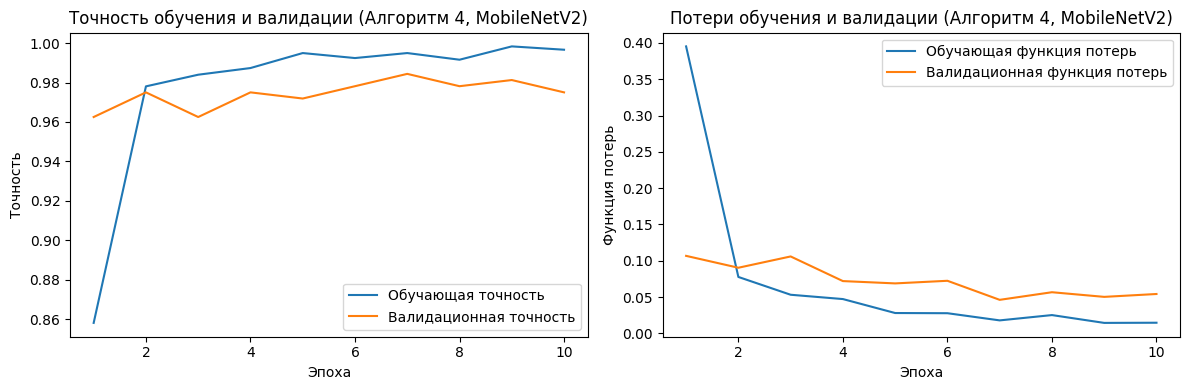

In [ ]:
acc      = history4.history["accuracy"]
val_acc  = history4.history["val_accuracy"]
loss     = history4.history["loss"]
val_loss = history4.history["val_loss"]
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Обучающая точность")
plt.plot(epochs, val_acc, label="Валидационная точность")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность обучения и валидации (Алгоритм 4, MobileNetV2)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Обучающая функция потерь")
plt.plot(epochs, val_loss, label="Валидационная функция потерь")
plt.xlabel("Эпоха")
plt.ylabel("Функция потерь")
plt.title("Потери обучения и валидации (Алгоритм 4, MobileNetV2)")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import gc
import tensorflow as tf
import numpy as np

# 1) Очистка памяти GPU/TPU
tf.keras.backend.clear_session()
gc.collect()

# 2) Удаление предыдущих моделей и датасетов
try:
    del model4, model5, base_model
    del train_ds, val_ds, test_ds, full_ds
    del history4, history_fine, history_combined
except:
    pass

# 3) Современная очистка для TF 2.x (set_learning_phase устарел)
tf.config.optimizer.set_jit(False)  # XLA off
gc.collect()

# 4) Проверка GPU памяти
try:
    gpu_info = tf.config.experimental.get_memory_info('GPU:0')
    print(f"✅ Память очищена. GPU: {gpu_info['current'] / 1e9:.1f} GB")
except:
    print("✅ Память очищена (CPU mode)")

print("🚀 Готов к Алгоритму 5!")


✅ Память очищена (CPU mode)
🚀 Готов к Алгоритму 5!


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
import matplotlib.pyplot as plt

print("=== АЛГОРИТМ 5: Fine-tuning MobileNetV2 (полная перезагрузка) ===")

# 1) Пересоздаём датасеты и MobileNetV2 с нуля
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
train_root = "./data/NEU Metal Surface Defects Data/train"

full_ds = tf.keras.utils.image_dataset_from_directory(
    train_root, image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=42, shuffle=True
)
class_names = full_ds.class_names
num_classes = len(class_names)

# Разделение на train/val/test
total = tf.data.experimental.cardinality(full_ds).numpy()
train_ds = full_ds.take(30).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = full_ds.skip(30).take(4).cache().prefetch(tf.data.AUTOTUNE)
test_ds = full_ds.skip(34)

# 2) Создаём MobileNetV2 заново (как в Алгоритме 4)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

base_model = applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model5 = tf.keras.Model(inputs, outputs)
model5.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Быстрое обучение базовой модели (10 эпох)
print("🔄 Быстрое обучение базовой MobileNetV2...")
history_base = model5.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

test_loss_base, test_acc_base = model5.evaluate(test_ds, verbose=0)
print(f"Базовая MobileNetV2: test acc = {test_acc_base:.4f}")

# 3) Fine-tuning: размораживаем последние 20 слоёв
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model5.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Маленький LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print(f"🔄 Fine-tuning последних {len(base_model.layers) - fine_tune_at} слоёв...")
history_fine = model5.fit(
    train_ds, validation_data=val_ds, epochs=5, verbose=1
)

test_loss5, test_acc5 = model5.evaluate(test_ds, verbose=0)
print(f"\n✅ Fine-tune результат: {test_acc5:.4f}")
print(f"Улучшение: {test_acc5 - test_acc_base:+.4f}")


=== АЛГОРИТМ 5: Fine-tuning MobileNetV2 (полная перезагрузка) ===
Found 1656 files belonging to 6 classes.
🔄 Быстрое обучение базовой MobileNetV2...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 591ms/step - accuracy: 0.6156 - loss: 1.0977 - val_accuracy: 0.9062 - val_loss: 0.2598
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 503ms/step - accuracy: 0.9704 - loss: 0.1155 - val_accuracy: 0.9609 - val_loss: 0.1075
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 547ms/step - accuracy: 0.9683 - loss: 0.0998 - val_accuracy: 0.9766 - val_loss: 0.0709
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 522ms/step - accuracy: 0.9918 - loss: 0.0514 - val_accuracy: 0.9766 - val_loss: 0.0773
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 506ms/step - accuracy: 0.9929 - loss: 0.0248 - val_accuracy: 0.9688 - val_loss: 0.0824
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 504ms/step - accuracy: 0.9982 - loss: 0.0168 - val_accuracy: 0.9688 - val_loss: 0.0811
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 508ms/step - accuracy: 0.9967 - los

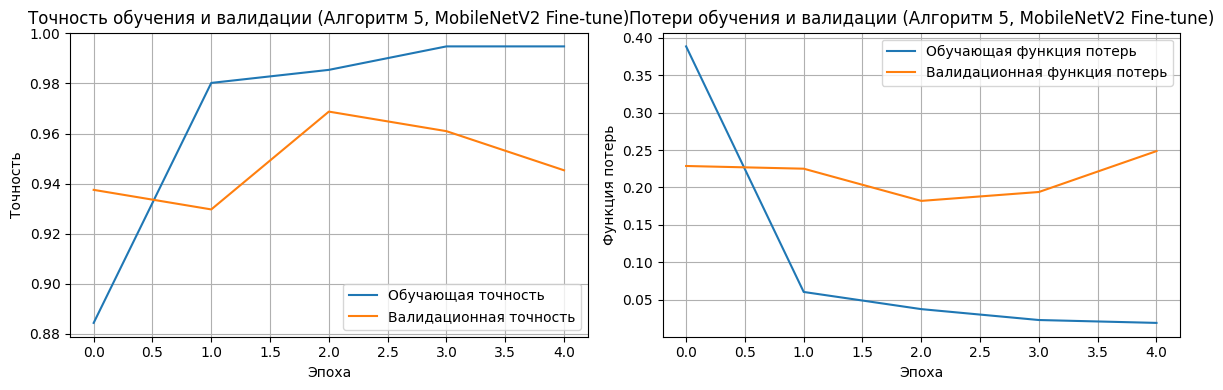

✅ Алгоритм 5: test accuracy = 0.9296


In [ ]:
import matplotlib.pyplot as plt

# График ТОЛЬКО для Алгоритма 5 (как у алгоритмов 1-4)
plt.figure(figsize=(12, 4))

# Точность
plt.subplot(1, 2, 1)
plt.plot(history_fine.history["accuracy"], label="Обучающая точность")
plt.plot(history_fine.history["val_accuracy"], label="Валидационная точность")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность обучения и валидации (Алгоритм 5, MobileNetV2 Fine-tune)")
plt.legend()
plt.grid(True)

# Потери
plt.subplot(1, 2, 2)
plt.plot(history_fine.history["loss"], label="Обучающая функция потерь")
plt.plot(history_fine.history["val_loss"], label="Валидационная функция потерь")
plt.xlabel("Эпоха")
plt.ylabel("Функция потерь")
plt.title("Потери обучения и валидации (Алгоритм 5, MobileNetV2 Fine-tune)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"✅ Алгоритм 5: test accuracy = {test_acc5:.4f}")
